In [15]:
from __future__ import division

import os
import operator
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle

from skimage import transform 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

# share GPU
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.49
set_session(tf.Session(config=config))

%matplotlib inline

In [16]:
def plot_images(images, max_col=4, file_name='', to_file=False):
    plt.figure(figsize=(8,8))
    rows = (len(images)-1)// max_col + 1
    
    for ix, image in enumerate(images):
        plt.subplot(rows, max_col, ix+1)
        plt.imshow(image.reshape(28, 28), cmap='gray_r')
    plt.tight_layout()
    plt.show()

In [17]:
# data constants
max_size = (32, 32)
data_files = {'cifar': '../data/cifar.npy',
              'mnist': '../data/mnist.npy',
              'lfw': '../data/lfw.npy'}

# load and transform data
data = np.load(data_files['mnist'])
data = data.astype('float32')

if data.shape[1:3] > max_size:
    data = np.array([transform.resize(image, max_size, preserve_range=True, order=0)] 
                    for image in data)

# shuffle data
np.random.shuffle(data)

# 
data_count = data.shape[0]
data_size = data.shape[1:3]
data_dim = reduce(operator.mul, data.shape[1:])

print 'Loaded data {}'.format(data.shape)

Loaded data (70000, 28, 28, 1)


In [18]:
# latent space generators
def get_uniform_space(high, low, space_size):
    return lambda batch_size: np.random.uniform(low, high, (batch_size, space_size)).astype('float32')

def get_gaussian_space(mean, var, space_size):
    return lambda batch_size: np.random.normal(mean, var, (batch_size, space_size)).astype('float32')

In [19]:
def get_mlp_model(input_dim):
    # setup optimizer
    opt = SGD(lr=0.01, momentum=0.1)

    leaky_alpha = 0.001
    # setup generator network
    generator = Sequential()
    generator.add(Dense(2048*2, input_dim=input_dim))
    generator.add(LeakyReLU(alpha=leaky_alpha))
    generator.add(Dense(1024*2))
    generator.add(LeakyReLU(alpha=leaky_alpha))
    generator.add(Dense(data_dim, activation='linear'))
    generator.compile(loss='binary_crossentropy', optimizer=opt)

    # setup discriminator network
    discriminator = Sequential()
    discriminator.add(Dense(2048, input_dim=data_dim))
    discriminator.add(LeakyReLU(alpha=leaky_alpha))
    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(alpha=leaky_alpha))
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=opt)

    # setup combined network
    gen_dis = Sequential()
    gen_dis.add(generator)
    discriminator.trainable = False
    gen_dis.add(discriminator)
    gen_dis.compile(loss='binary_crossentropy', optimizer=opt)
    return (generator, discriminator, gen_dis)

G: [0.60492104291915894]


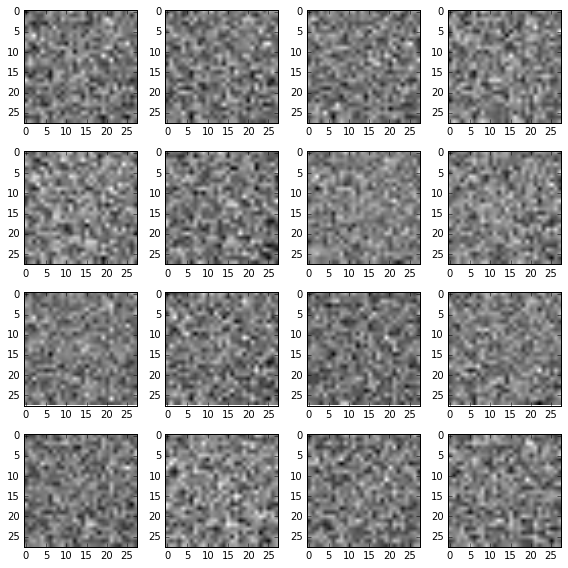

D: [6.0358118414878845]
D: [7.7761217355728149]
D: [7.7584273815155029]
D: [7.750495433807373]
G: [1.4808991551399231]
D: [7.7767660617828369]
D: [7.7616946697235107]
D: [7.7523019313812256]
D: [7.7457127571105957]
G: [1.5100798606872559]
D: [7.7750669717788696]
D: [7.7615382671356201]
D: [7.751096248626709]
D: [7.7469875812530518]
G: [1.5482726693153381]
D: [7.7742288112640381]
D: [7.7576837539672852]
D: [7.752224326133728]
D: [7.747638463973999]
G: [1.5369041562080383]
D: [7.7719980478286743]
D: [7.7583165168762207]
D: [7.7519547939300537]
D: [7.7476013898849487]
G: [1.5809428691864014]
D: [7.7643786668777466]
D: [7.7558413743972778]
D: [7.7495326995849609]
D: [7.7472906112670898]
G: [1.5712308883666992]
D: [7.7613174915313721]
D: [7.7531543970108032]
D: [7.7484527826309204]
D: [7.7474403381347656]
G: [1.6048499941825867]
D: [7.7558332681655884]
D: [7.7484475374221802]
D: [7.7475627660751343]
D: [7.7447187900543213]
G: [1.6395169496536255]
D: [7.7529542446136475]
D: [7.74841094017028

KeyboardInterrupt: 

In [24]:
# setup experiment
batch_size = 64
latent_space_size = data_dim
z_space = get_gaussian_space(0, 1, latent_space_size)
generator, discriminator, gen_dis = get_mlp_model(latent_space_size)

# prepare data
#gen_labels = np.ones(2*batch_size)
#gen_labels[:batch_size] = 0

# label smoothing/noise
gen_labels = np.random.uniform(low=0.7, high=1.2, size=2*batch_size)
gen_labels[:batch_size] = np.random.uniform(low=0.0, high=0.3, size=batch_size)

gen_disc_labels = np.ones(batch_size)

# put some noise in discriminator labels by setting some to zero
ten_percent = int((batch_size*2)/10)
import random
gen_disc_zero_labels = random.sample(range(0, batch_size), ten_percent)



for i in range(1000):
    z_samples = z_space(batch_size).astype('float32')
    n = np.random.randint(0, data_count-batch_size-1)
    x_samples = data[n: n+batch_size].reshape(batch_size, -1)
    
    if i % 5 == 0:
        g_hist = gen_dis.fit(z_samples, gen_disc_labels, epochs=1, verbose=0)
        print 'G:', g_hist.history['loss']
    else:
        d_hist = discriminator.fit(
            np.vstack([generator.predict(z_samples), x_samples]), 
            gen_labels, epochs=1,verbose=0)
        print 'D:', d_hist.history['loss']
    
    if i % 150 == 0:
        fakes = generator.predict(z_samples[:16,:])
        plot_images(fakes)

In [28]:
gen_disc_zero_labels.sort()

In [27]:
sort(gen_disc_zero_labels)

array([ 0,  8, 20, 22, 28, 29, 32, 43, 45, 48, 54, 58])